In [2]:
%matplotlib inline

In [33]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict
import tabulate
import time
import GPy
from IPython.display import display

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Monthly transaction data

In [112]:
# month_to_num snippet from:
# https://stackoverflow.com/questions/3418050/month-name-to-month-number-and-vice-versa-in-python

import calendar
month_to_num = dict((v,k) for k,v in enumerate(calendar.month_abbr))

transaction_data = pandas.read_csv('data/transactions/anonymized.csv')
transaction_data['day'] = [int(d[:2]) for d in transaction_data.Date]
transaction_data['month_year'] = [d[2:] for d in transaction_data.Date]
transaction_data['month'] = [d[2:5] for d in transaction_data.Date]
transaction_data['month_num'] = [month_to_num[m] for m in transaction_data.month]
transaction_data['year'] = [int(d[5:]) for d in transaction_data.Date]
transaction_data['day_of_week'] = [date(row.year, row.month_num, row.day).weekday() 
                                   for _, row in transaction_data.iterrows()]

AMOUNT_SHIFT = min(transaction_data.Amount) - 1
transaction_data['shifted_amount'] = transaction_data.Amount - AMOUNT_SHIFT
transaction_data['log_shifted_amount'] = np.log(transaction_data.shifted_amount)
transaction_data.log_shifted_amount = transaction_data.log_shifted_amount.replace(0, None).dropna()

transaction_data.head()

,Date,Amount,day,month_year,month,month_num,year,day_of_week,shifted_amount,log_shifted_amount
0,25May2016,54241.35,25,May2016,May,5,2016,2,95297.30,11.464757
1,29May2017,54008.83,29,May2017,May,5,2017,0,95064.78,11.462314
2,30Jun2017,54008.82,30,Jun2017,Jun,6,2017,4,95064.77,11.462314
3,05Jan2017,52704.37,5,Jan2017,Jan,1,2017,3,93760.32,11.448497
4,23Feb2017,52704.36,23,Feb2017,Feb,2,2017,3,93760.31,11.448497


In [39]:
transaction_data.groupby('day_of_week').count()

,Date,Amount,day,month_year,month,month_num,year
day_of_week,,,,,,,
0,571,571,571,571,571,571,571
1,495,495,495,495,495,495,495
2,384,384,384,384,384,384,384
3,370,370,370,370,370,370,370
4,356,356,356,356,356,356,356
5,342,342,342,342,342,342,342


In [252]:
from sklearn.neighbors.kde import KernelDensity

FIGURE_SIZE = (8, 6)

def fit_and_plot(series, kde_bandwidth, hist_name, 
                 hist_bins, hist_title, axes=None, pre_kernel_transform=lambda x: x):
    density_data = pre_kernel_transform(series.as_matrix().reshape((-1, 1)))
    kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(density_data)
    x_range = np.linspace(min(series), max(series), 100).reshape((-1, 1))
    y_density = np.exp(kde.score_samples(x_range))
    
    if axes:
        series.hist(bins=hist_bins, normed=True, ax=axes)
        should_show = False
    else:
        axes = series.hist(bins=hist_bins, normed=True, figsize=FIGURE_SIZE)
        should_show = True
        
    axes.plot(x_range, y_density, color='blue', label='Fit density')
    plt.legend(loc=1, fontsize=12)
    plt.xlabel(hist_title, size=12)
    plt.ylabel(r'Frequency', size=12)
    plt.title(hist_title)
    
    if should_show:
        plt.show()
    
    return kde

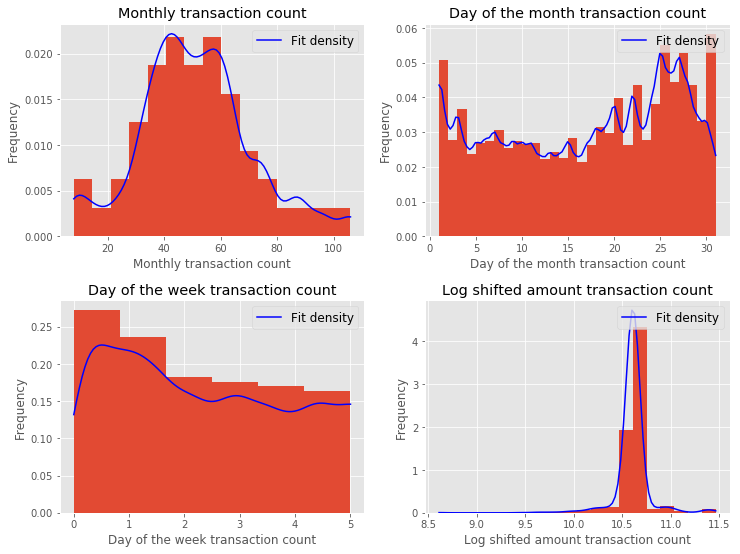

In [272]:
plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(2, 2, hspace=0.3)

counts_by_month = transaction_data.groupby('month_year').count()
month_count_kde = fit_and_plot(counts_by_month.Amount, 4, 'Amount', 15, 
                               'Monthly transaction count', plt.subplot(gs[0, 0]))

day_count_kde = fit_and_plot(transaction_data.day, 0.5, 'day', 30, 
                             'Day of the month transaction count', plt.subplot(gs[0, 1]))

k = 10
day_of_week_count_kde = fit_and_plot(transaction_data.day_of_week, 0.25, 'day_of_week', 6, 
                                     'Day of the week transaction count', plt.subplot(gs[1, 0]),
                                     lambda m: m + (np.random.choice(list(range(k)), m.shape) / k))

log_shifted_amount_kde = fit_and_plot(transaction_data.log_shifted_amount, 0.07, 
                                      'log_shifted_amount', 20, 
                                      'Log shifted amount transaction count', plt.subplot(gs[1, 1]))

plt.show()

In [226]:
def generate_fake_month():
    monthly_transactions = month_count_kde.sample().astype(int)[0][0]
    day_of_months = day_count_kde.sample(monthly_transactions * 2).astype(int).reshape((1, -1))[0]
    day_of_months = list(filter(lambda x: x >= 1 and x <= 31, day_of_months))[:monthly_transactions]
    shifted_log_amounts = log_shifted_amount_kde.sample(monthly_transactions).reshape((1, -1))[0]
    amounts = np.exp(shifted_log_amounts) + AMOUNT_SHIFT
    return day_of_months, amounts

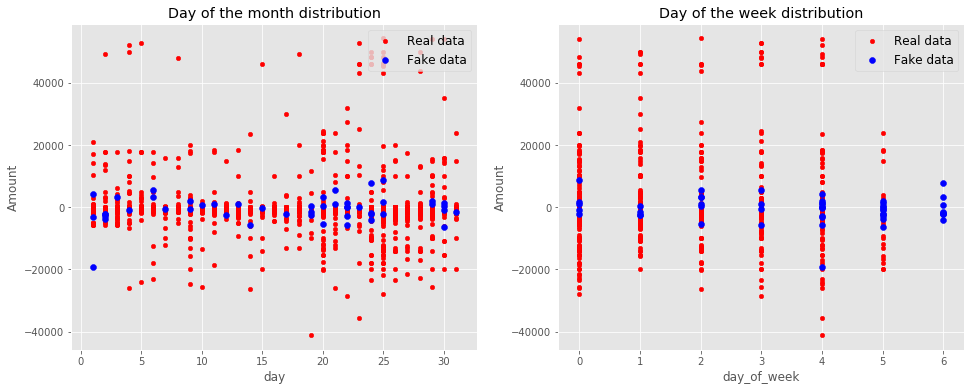

In [289]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, hspace=0.7)

days, amounts = generate_fake_month()
axes = transaction_data.plot('day', 'Amount', kind='scatter', #figsize=FIGURE_SIZE, 
                             color='red', label='Real data', ax=plt.subplot(gs[0, 0]))
axes.scatter(days, amounts, color='blue', label='Fake data')
plt.legend(loc=1, fontsize=12)
plt.title('Day of the month distribution')
# plt.show()

axes = transaction_data.plot('day_of_week', 'Amount', kind='scatter', #figsize=FIGURE_SIZE, 
                             color='red', label='Real data', ax=plt.subplot(gs[0, 1]))
dec_2017_day_of_weeks = [date(2017, 12, day).weekday() for day in days]
axes.scatter(dec_2017_day_of_weeks, amounts, color='blue', label='Fake data')
plt.legend(loc=1, fontsize=12)
plt.title('Day of the week distribution')

plt.show()

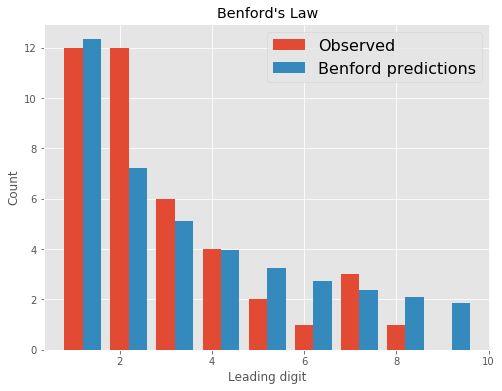

In [243]:
# expected number of each leading digit per Benford's law
# borrowed from https://www.johndcook.com/blog/2011/10/19/benfords-law-and-scipy/
leading_digits = [int(str(abs(x))[0]) for x in amounts]
leading_counts = [leading_digits.count(x) for x in range(1, 10)]
benford = [len(amounts) * np.log10(1 + 1/i) for i in range(1, 10)]

plt.figure(figsize=FIGURE_SIZE)
plt.bar(range(1, 10), leading_counts, width=0.4, label='Observed')
plt.bar([x + 0.4 for x in range(1, 10)], benford, width=0.4, label='Benford predictions')

plt.legend(loc=1, fontsize=16)
plt.title('Benford\'s Law')
plt.xlabel('Leading digit')
plt.ylabel('Count')
plt.show()

In [220]:
days

32